<a href="https://colab.research.google.com/github/piltom/materia_machinelearning/blob/main/ResolucionTP1_AlvarezVanoli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resolución TP1
Una alternativa para clasificar los datos nuevos es considerar a las distribuciones como funciones de x o y. Para esto, dependiendo de cual considere la variable independiente (mirando la suryectividad de la función), remuevo los outliers. Después calculo la varianza en la diferencia entre valores sucesivos de la variable dependiente. Si la varianza es alta, es una funcion que se comporta más "aleatoriamente", por lo que para ver que punto pertenece más a ese conjunto, me fijo en el punto que menos modifique esa varianza intermuestra. Si la varianza es baja, es posible que se trate de una función polinomial o suave al menos, por lo que me fijo entre la diferencia de la derivada anterior al punto nuevo y la derivada en el punto nuevo si se añadiese donde corresponde.

In [2]:
import pandas as pd          # import pandas
import seaborn as sns        # import seaborn, we will be using anscombe dataset and sns.FacetGrid
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, GroupKFold
import matplotlib.pyplot as plt  # import pyplot to create scatter plots
from scipy import stats #to use zscore


pd.set_option("max_rows", 8)              # only display up to 8 rows when printing dataframes (reduce visual clutter)
anscome_df = sns.load_dataset("anscombe") # load anscombe dataset from seaborn
anscome_df['x'] = anscome_df['x'].astype(float)
anscome_df['y'] = anscome_df['y'].astype(float)

grouped = anscome_df.groupby('dataset')   #agrupo por dataset

datos = pd.DataFrame(np.array([[16, 8], [8,6], [16,10], [16, 6]]), columns=['x', 'y']) #datos a introducir
datos

,x,y
0,16,8
1,8,6
2,16,10
3,16,6


Luego para cada set y para cada punto se realizan las cuentas descritas al principio:

In [48]:
metrics_wp = []   #simscore para cada punto contra cada dataset
for key in grouped.groups.keys():
    data = grouped.get_group(key)
    inverted = False    #flag si inverti la funcion
    if len(np.unique(data['x'].values))==len(data['x'].values): #si es funcion suryectiva de x
      data = data.sort_values(by='x')
      not_outliers= list(map(lambda x: np.abs(x) < 2.5, stats.zscore(data['y'])))  #saco los outliers, 2.5 desviaciones de la media
      X_x = data['x'].values[not_outliers]
      y_x = data['y'].values[not_outliers]
      X_new= datos['x'].values
      y_new= datos['y'].values
    else:     #sino invierto la funcion (puede fallar al no ser suryectiva en y, aunque no con estos conjuntos)
      inverted = True
      data = data.sort_values(by='y')
      not_outliers= list(map(lambda x: np.abs(x) < 2.5, stats.zscore(data['x'])))
      X_x = data['y'].values[not_outliers]
      y_x = data['x'].values[not_outliers]
      X_new= datos['y'].values
      y_new= datos['x'].values
    dx = X_x[1:]-X_x[:-1]
    dy = y_x[1:]-y_x[:-1]
    dy_var  = np.var(dy)
    for i in range(len(X_new)):
      new_idx=np.searchsorted(X_x,X_new[i])
      prev_derivative=(y_x[new_idx-1]-y_x[new_idx-2])/(X_x[new_idx-1]-X_x[new_idx-2])
      derivative=(y_new[i]-y_x[new_idx-1])/(X_new[i]-X_x[new_idx-1])
      dy_var_wp=np.var(np.append(dy,y_new[i]-y_x[new_idx-1]))
      if dy_var>1:
        sim_score = abs(dy_var-dy_var_wp)   #Si tiene grandes saltos, clasifico por varianza
      else:
        sim_score = abs(derivative-prev_derivative)  #sino por suavidad (derivadas)
      if not inverted:
        metrics_wp.append({'x':X_new[i], 'y':y_new[i],'dataset':key,'sim_score':sim_score })
      else:
        metrics_wp.append({'x':y_new[i], 'y':X_new[i],'dataset':key,'sim_score':sim_score })

metrics_df= pd.DataFrame(metrics_wp)
grouped_metrics = metrics_df.groupby('dataset')   #agrupo por dataset
metrics_df.iloc[grouped_metrics['sim_score'].idxmin().values]

,x,y,dataset,sim_score
0,16,8,I,0.180609
7,16,6,II,0.410000
10,16,10,III,0.235000
13,8,6,IV,0.000000


Añadidos a los nuevos puntos a cada set, los gráficos resultan:

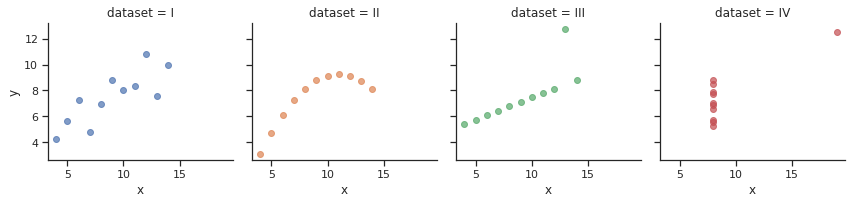

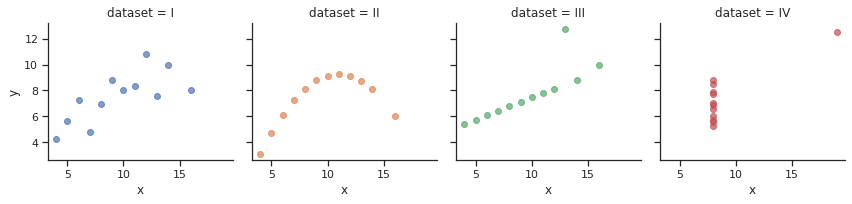

In [47]:
clasif_df = metrics_df.iloc[grouped_metrics['sim_score'].idxmin().values].drop('sim_score', axis=1)
anscome_solved_df=pd.concat([anscome_df,clasif_df], ignore_index=True)

sns.set(style="ticks")
g1 = sns.FacetGrid(anscome_df, col="dataset", hue="dataset") # define a grid of plots. Each element shows a different memeber from the quartet in a different column and color

g2 = sns.FacetGrid(anscome_solved_df, col="dataset", hue="dataset") # define a grid of plots. Each element shows a different memeber from the quartet in a different column and color
g1.map(plt.scatter, "x", "y", alpha=.7)                      # render scatterplots
g2.map(plt.scatter, "x", "y", alpha=.7)                      # render scatterplots